In [3]:
import numpy as np
import torch
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
import torch.nn.functional as F

import pandas as pd
import anndata
import scvelo as scv
import scanpy

from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import kneighbors_graph

In [38]:
root = "./"
tree_files = ['cycle/rand1/']
data_list = []

file_name = tree_files[0]
X_unspliced = pd.read_csv(root + file_name + "unspliced_counts.txt", sep="\t",header=None).to_numpy().T
X_spliced = pd.read_csv(root + file_name + "spliced_counts.txt", sep = "\t",header=None).to_numpy().T
true_velo = pd.read_csv(root + file_name + "true_velo.txt", sep="\t",header=None).to_numpy().T
true_time = pd.read_csv(root + file_name + "true_time.txt", sep = "\t",lineterminator="\n", header = None).to_numpy()
X_obs = pd.DataFrame(data=true_time, index = ['cell_' + str(x) for x in range(X_unspliced.shape[0])], columns = ['sim_time'])


adata_ori = anndata.AnnData(X = csr_matrix(X_spliced),
                obs = X_obs,
                layers = dict(
                    unspliced = csr_matrix(X_unspliced),
                    spliced = csr_matrix(X_spliced),
                    true_velo = true_velo
                ))

adata = adata_ori.copy()

scv.pp.filter_and_normalize(adata, min_shared_counts=0, n_top_genes=1000)
print("cycle dimension ",adata.n_vars)

# compute velocity
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
scv.tl.velocity(adata, mode='stochastic')            
velo_matrix = adata.layers["velocity"].copy()

bias = np.concatenate((np.exp(-0.5*np.linspace(0,3,100)**2)[::-1],np.ones(velo_matrix.shape[0]-200),np.exp(-0.5*np.linspace(0,3,100)**2)), axis = None)[:,None]
velo_matrix = bias * velo_matrix
adata.layers['velocity'] = velo_matrix

X_spliced = adata.X.toarray()

pipeline = Pipeline([('pca', PCA(n_components=80, svd_solver='arpack'))])
X_pca = pipeline.fit_transform(X_spliced)

X_pre = X_spliced + velo_matrix * 0.1
# X_pre = X_spliced + velo_matrix

X_pca_pre = pipeline.transform(X_pre)
velo_pca = X_pca_pre - X_pca

directed_conn = kneighbors_graph(X_pca, n_neighbors=10, mode='connectivity', include_self=False).toarray()
conn = directed_conn + directed_conn.T
conn[conn.nonzero()[0],conn.nonzero()[1]] = 1

# X_spliced is original, X_pca is after pca
x = X_spliced.copy()
x = StandardScaler().fit_transform(x)
x = torch.FloatTensor(x)

# X_pca_pre is after pca
v = StandardScaler().fit_transform(X_pre)
v = torch.FloatTensor(v)

# Simulation time label
y = adata.obs['sim_time'].to_numpy().reshape((-1, 1))
scaler = MinMaxScaler((0, 1))
scaler.fit(y)
y = torch.FloatTensor(scaler.transform(y).reshape(-1, 1))

# Graph type label
# y = torch.LongTensor(np.where(np.array(backbones) == bb)[0])

edge_index = np.array(np.where(conn == 1))
edge_index = torch.LongTensor(edge_index)

data = Data(x=x, edge_index=edge_index, y=y, v=v)
data_list.append(data)

Skip filtering by dispersion since number of variables are less than `n_top_genes`
Logarithmized X.
cycle dimension  300
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [39]:
def add_arrow(line, position=None, arrow_line = True, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    
    if direction == 'right':
        start_ind = 0
        end_ind = 1
    else:
        end_ind = 0
        start_ind = 1

    if arrow_line:
        line.axes.annotate('',
            xytext=(xdata[start_ind], ydata[start_ind]),
            xy=(xdata[end_ind], ydata[end_ind]),
            arrowprops=dict(arrowstyle="->", color=color),
            size=size
        )
    else:
        line.axes.annotate('',
            xytext=(xdata[start_ind], ydata[start_ind]),
            xy=(xdata[end_ind], ydata[end_ind]),
            arrowprops=dict(arrowstyle="-", color=color),
            size=size
        )

In [40]:
import matplotlib.pyplot as plt

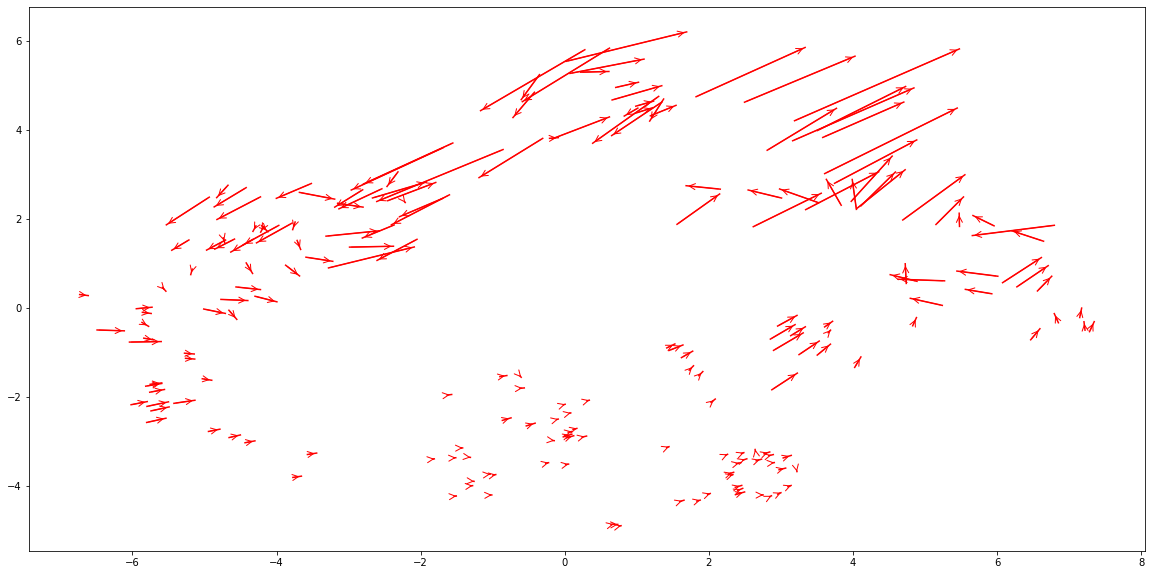

In [42]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
for cell in range(X_spliced.shape[0]):
    line = ax.plot([X_pca[cell,0],X_pca_pre[cell,0]],[X_pca[cell,1],X_pca_pre[cell,1]], 'r-')
    add_arrow(line[0])


computing velocity graph
... 100%    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


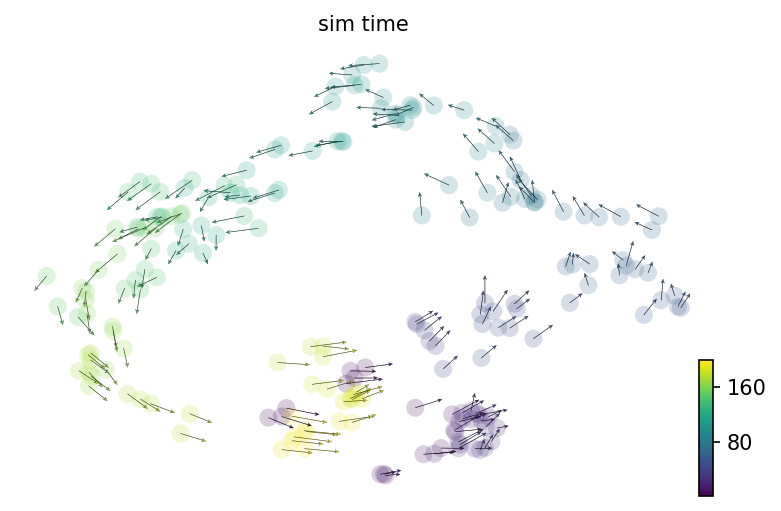

In [14]:
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding(adata, dpi=150, color=['sim_time'],arrow_length=5)